## Introduction

La détection de pose (également connue sous le nom d'estimation de pose) est une tâche de vision par ordinateur largement utilisée qui permet de prédire les poses humaines dans des images ou des vidéos en localisant les articulations clés du corps (également appelées points de repère), tels que les coudes, les épaules et les genoux, etc.

**MediaPipe** offre une solution robuste capable de prédire trente-trois points de repère 3D sur un corps humain en temps réel avec une grande précision, même sur un CPU. Il utilise un pipeline d'apprentissage automatique en deux étapes : en premier lieu, un détecteur localise la personne dans le cadre, puis un détecteur de points de repère de pose prédit les points de repère dans la région d'intérêt.


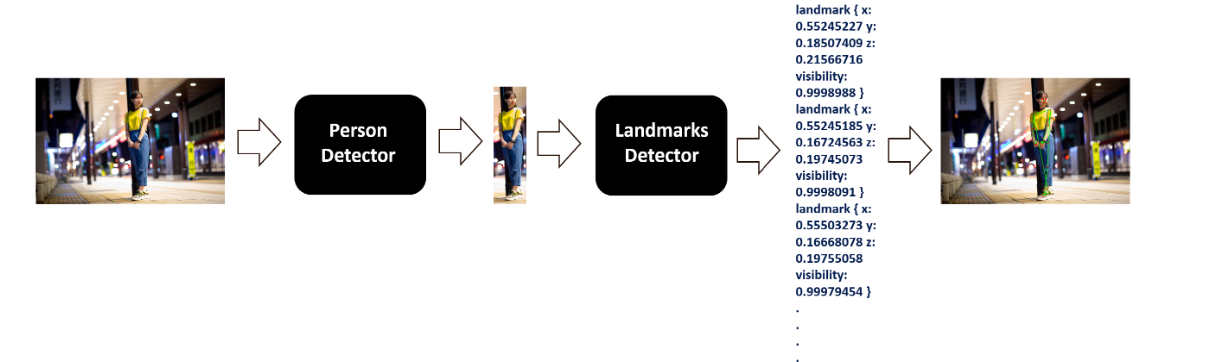

Pour les vidéos, le détecteur est utilisé uniquement pour la toute première image, puis la région d'intérêt (ROI) est dérivée des points de repère de pose du cadre précédent en utilisant une méthode de suivi. De plus, lorsque le suiveur perd la trace de la présence de la pose corporelle dans un cadre, le détecteur est de nouveau invoqué pour le cadre suivant, ce qui réduit le calcul et la latence. L'image ci-dessous montre les trente-trois points de repère de pose ainsi que leurs indices.


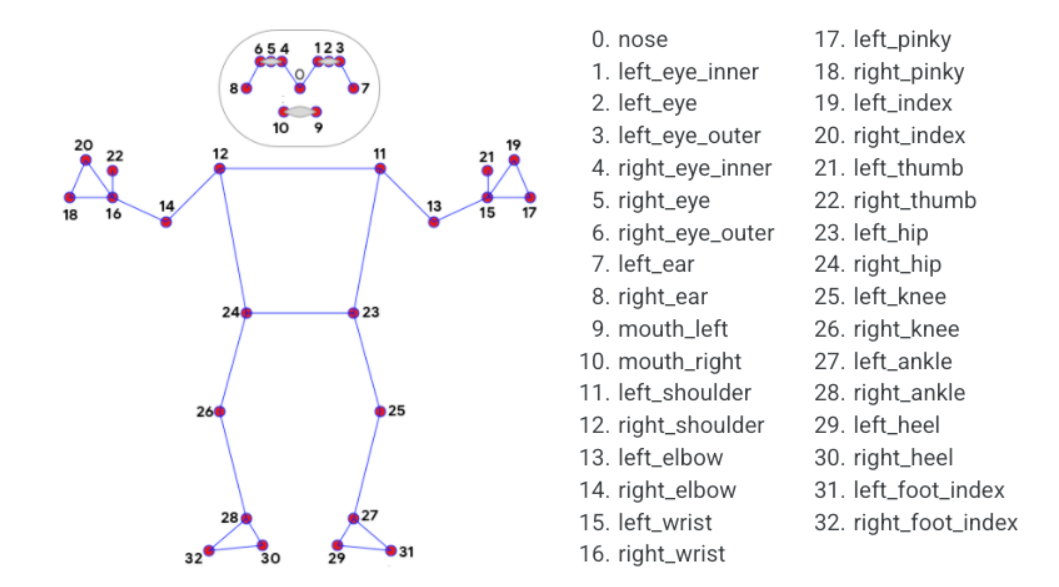

## import libraries

In [2]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

### Initialisation du Modèle de Détection de Pose

Pour commencer à utiliser le modèle de détection de pose, suivez les étapes ci-dessous :

1. **Initialisation de la Classe de Pose**

   Nous devons initialiser la classe de pose en utilisant `mp.solutions.pose` et en appelant la fonction de configuration `mp.solutions.pose.Pose()` avec les arguments suivants :

   - **`static_image_mode`** : 
     - **Type** : Booléen
     - **Description** : Détermine si le détecteur est invoqué uniquement au besoin (dans la première image ou lorsque le tracker perd la piste) (`False`) ou sur chaque image d'entrée (`True`). Utilisez `True` pour un ensemble d'images non liées (non vidéos). La valeur par défaut est `False`.

   - **`min_detection_confidence`** :
     - **Type** : Flottant (0.0 à 1.0)
     - **Description** : Confiance minimale de détection requise pour considérer la prédiction du modèle de détection de personne comme correcte. Si la confiance de la prédiction est supérieure ou égale à 50%, elle sera considérée comme une détection positive. La valeur par défaut est `0.5`.

   - **`min_tracking_confidence`** :
     - **Type** : Flottant (0.0 à 1.0)
     - **Description** : Confiance minimale de suivi requise pour que les points de repère suivis par le modèle soient considérés comme valides. Une confiance inférieure à la valeur définie entraînera une nouvelle invocation du détecteur dans la prochaine image. Une valeur plus élevée augmente la robustesse mais aussi la latence. La valeur par défaut est `0.5`.

   - **`model_complexity`** :
     - **Type** : Entier (0, 1 ou 2)
     - **Description** : Complexité du modèle de points de repère de pose. Une valeur plus élevée offre des résultats plus précis mais avec une latence accrue. La valeur par défaut est `1`.

   - **`smooth_landmarks`** :
     - **Type** : Booléen
     - **Description** : Si `True`, les points de repère de pose sont filtrés à travers différentes images pour réduire le bruit. Cela fonctionne uniquement lorsque `static_image_mode` est également réglé sur `False`. La valeur par défaut est `True`.

2. **Visualisation des Points de Repère**

   Après avoir détecté les points de repère, vous pouvez utiliser la classe `mp.solutions.drawing_utils` pour visualiser les points de repère sur les images. Alternativement, vous pouvez également utiliser OpenCV pour cette visualisation.

   ```python
   import mediapipe as mp

   mp_pose = mp.solutions.pose
   pose = mp_pose.Pose(
       static_image_mode=False,
       min_detection_confidence=0.5,
       min_tracking_confidence=0.5,
       model_complexity=1,
       smooth_landmarks=True
   )

   mp_drawing = mp.solutions.drawing_utils


In [3]:
mp_pose = mp.solutions.pose

# Configuration de la fonction Pose.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initialisation de la classe de dessin MediaPipe, utile pour l'annotation.
mp_drawing = mp.solutions.drawing_utils 


### Lecture d'une Image

Pour lire et afficher une image en utilisant OpenCV et Matplotlib, suivez les étapes ci-dessous :

1. **Lecture de l'Image**

   Utilisez la fonction `cv2.imread()` d'OpenCV pour lire une image depuis un fichier. Cette fonction charge l'image en mémoire et la renvoie sous forme de tableau NumPy.

   ```python
   import cv2

   # Spécifiez le chemin vers votre image
   image_path = 'chemin/vers/votre/image.jpg'

   # Lire l'image à l'aide de cv2.imread()
   image = cv2.imread(image_path)


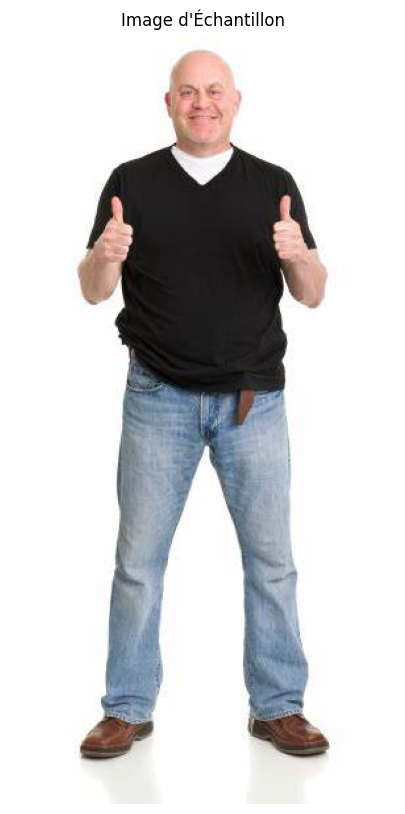

In [4]:
sample_img = cv2.imread('media/sample.jpg')

# Spécifier la taille de la figure.
plt.figure(figsize=[10, 10])

# Afficher l'image d'échantillon, en convertissant également BGR en RGB pour l'affichage.
plt.title("Image d'Échantillon"); plt.axis('off'); plt.imshow(sample_img[:,:,::-1]); plt.show()


## Exécuter la Détection de Pose

Nous allons maintenant transmettre l'image au pipeline de détection de pose en utilisant la fonction `mp.solutions.pose.Pose().process()`. Cependant, le pipeline attend des images en format couleur RGB, donc nous devrons d'abord convertir l'image d'exemple du format BGR au format RGB en utilisant la fonction `cv2.cvtColor()` car OpenCV lit les images en format BGR (au lieu de RGB).

Après avoir réalisé la détection de pose, nous obtiendrons une liste de trente-trois repères représentant les emplacements des articulations du corps de la personne principale dans l'image. Chaque repère a :

- `x` : Il s'agit de la coordonnée x du repère normalisée à [0.0, 1.0] en fonction de la largeur de l'image.
- `y` : Il s'agit de la coordonnée y du repère normalisée à [0.0, 1.0] en fonction de la hauteur de l'image.
- `z` : Il s'agit de la coordonnée z du repère normalisée à peu près à la même échelle que x. Elle représente la profondeur du repère avec le milieu des hanches comme origine, donc plus la valeur de z est petite, plus le repère est proche de la caméra.

- `visibility` : Il s'agit d'une valeur avec une plage de [0.0, 1.0] représentant la probabilité que le repère soit visible (non obstrué) dans l'image. C'est une variable utile lorsque vous décidez si vous souhaitez afficher une articulation particulière car elle pourrait être obstruée ou partiellement visible dans l'image.

Après avoir effectué la détection de pose sur l'image d'exemple ci-dessus, nous afficherons les deux premiers repères de la liste, afin que vous ayez une meilleure idée de la sortie du modèle.


In [5]:
# Traiter l'image avec la fonction Pose en convertissant d'abord BGR en RGB.
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

# Vérifier si des repères sont trouvés.
if results.pose_landmarks:
    
    # Itérer deux fois car nous souhaitons uniquement afficher les deux premiers repères.
    for i in range(2):
        
        # Afficher les repères normalisés trouvés.
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}')


NOSE:
x: 0.498084366
y: 0.0940485895
z: -0.842534781
visibility: 0.999863

LEFT_EYE_INNER:
x: 0.524116218
y: 0.0787589252
z: -0.762378275
visibility: 0.999734



d:\2perfect\e_learning\e_learning\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Nous allons maintenant convertir les deux points de repère normalisés affichés ci-dessus dans leur échelle d'origine en utilisant la largeur et la hauteur de l'image.

In [6]:
image_height, image_width, _ = sample_img.shape

# Vérifier si des repères sont trouvés.
if results.pose_landmarks:
    
    # Itérer deux fois car nous souhaitons uniquement afficher les deux premiers repères.
    for i in range(2):
        
        # Afficher les repères trouvés après les avoir convertis à leur échelle d'origine.
        print(f'{mp_pose.PoseLandmark(i).name}:') 
        print(f'x: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x * image_width}')
        print(f'y: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y * image_height}')
        print(f'z: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z * image_width}')
        print(f'visibility: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].visibility}\n')


NOSE:
x: 145.93871933221817
y: 55.01842483878136
z: -246.86269068717957
visibility: 0.9998630285263062

LEFT_EYE_INNER:
x: 153.5660519003868
y: 46.07397124171257
z: -223.37683469057083
visibility: 0.9997339844703674



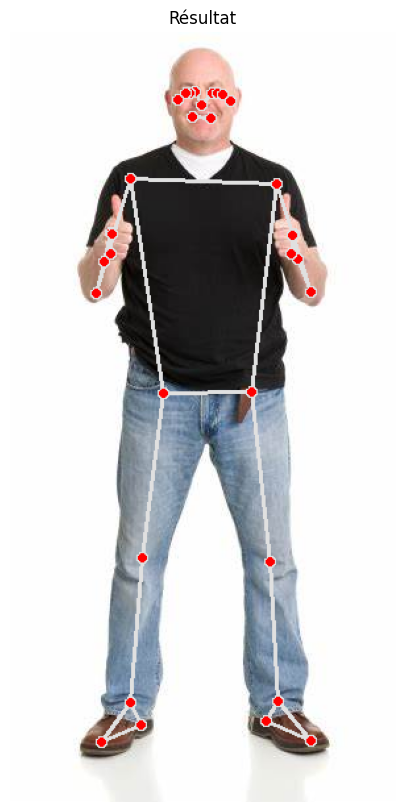

In [7]:
img_copy = sample_img.copy()

# Vérifier si des repères sont trouvés.
if results.pose_landmarks:
    
    # Dessiner les repères de pose sur l'image d'échantillon.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
       
    # Spécifier la taille de la figure.
    fig = plt.figure(figsize=[10, 10])

    # Afficher l'image résultante avec les repères dessinés, en convertissant également BGR en RGB pour l'affichage.
    plt.title("Résultat"); plt.axis('off'); plt.imshow(img_copy[:,:,::-1]); plt.show()


## Visualiser les Repères en Trois Dimensions

Nous allons aller un pas plus loin et visualiser les repères en trois dimensions (3D) en utilisant la fonction `mp.solutions.drawing_utils.plot_landmarks()`. Nous aurons besoin des `POSE_WORLD_LANDMARKS`, qui est une autre liste de repères de pose en coordonnées mondiales contenant les coordonnées 3D en mètres, avec l'origine au centre entre les hanches de la personne.


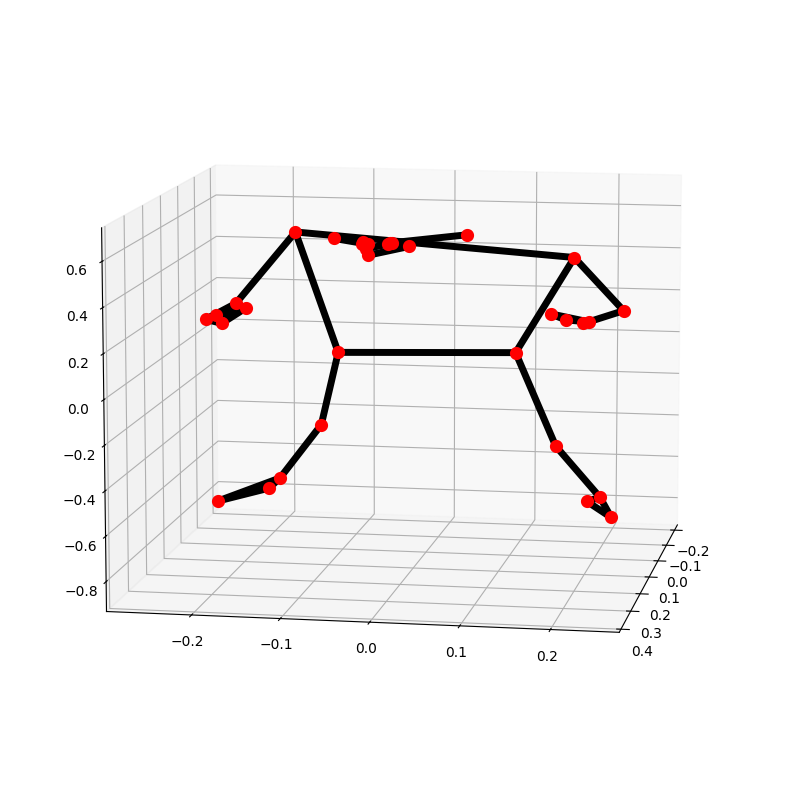

In [8]:
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

## Créer une Fonction de Détection de Pose

Maintenant, nous allons assembler tout cela pour créer une fonction qui effectuera la détection de pose sur une image et visualisera les résultats ou les renverra en fonction des arguments passés.


In [8]:
def detectPose(image, pose, display=True):
    '''
    Cette fonction réalise la détection de pose sur une image.
    Arguments:
        image: L'image d'entrée avec une personne visible dont les repères de pose doivent être détectés.
        pose: La fonction de configuration de pose requise pour effectuer la détection de pose.
        display: Un booléen qui, s'il est défini sur vrai, affiche l'image d'entrée originale, l'image résultante,
                 ainsi que les repères de pose dans un graphique 3D et ne retourne rien.
    Retourne:
        output_image: L'image d'entrée avec les repères de pose détectés dessinés.
        landmarks: Une liste de repères détectés convertis à leur échelle d'origine.
    '''
    
    # Créer une copie de l'image d'entrée.
    output_image = image.copy()
    
    # Convertir l'image du format BGR en format RGB.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Réaliser la détection de pose.
    results = pose.process(imageRGB)
    
    # Récupérer la hauteur et la largeur de l'image d'entrée.
    height, width, _ = image.shape
    
    # Initialiser une liste pour stocker les repères détectés.
    landmarks = []
    
    # Vérifier si des repères ont été détectés.
    if results.pose_landmarks:
    
        # Dessiner les repères de pose sur l'image de sortie.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        # Itérer sur les repères détectés.
        for landmark in results.pose_landmarks.landmark:
            
            # Ajouter le repère à la liste.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    # Vérifier si l'image d'entrée originale et l'image résultante doivent être affichées.
    if display:
    
        # Afficher l'image d'entrée originale et l'image résultante.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Image Originale");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Image Résultante");plt.axis('off');
        
        # Afficher également les repères de pose en 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    # Sinon
    else:
        
        # Retourner l'image de sortie et les repères trouvés.
        return output_image, landmarks


d:\2perfect\e_learning\e_learning\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


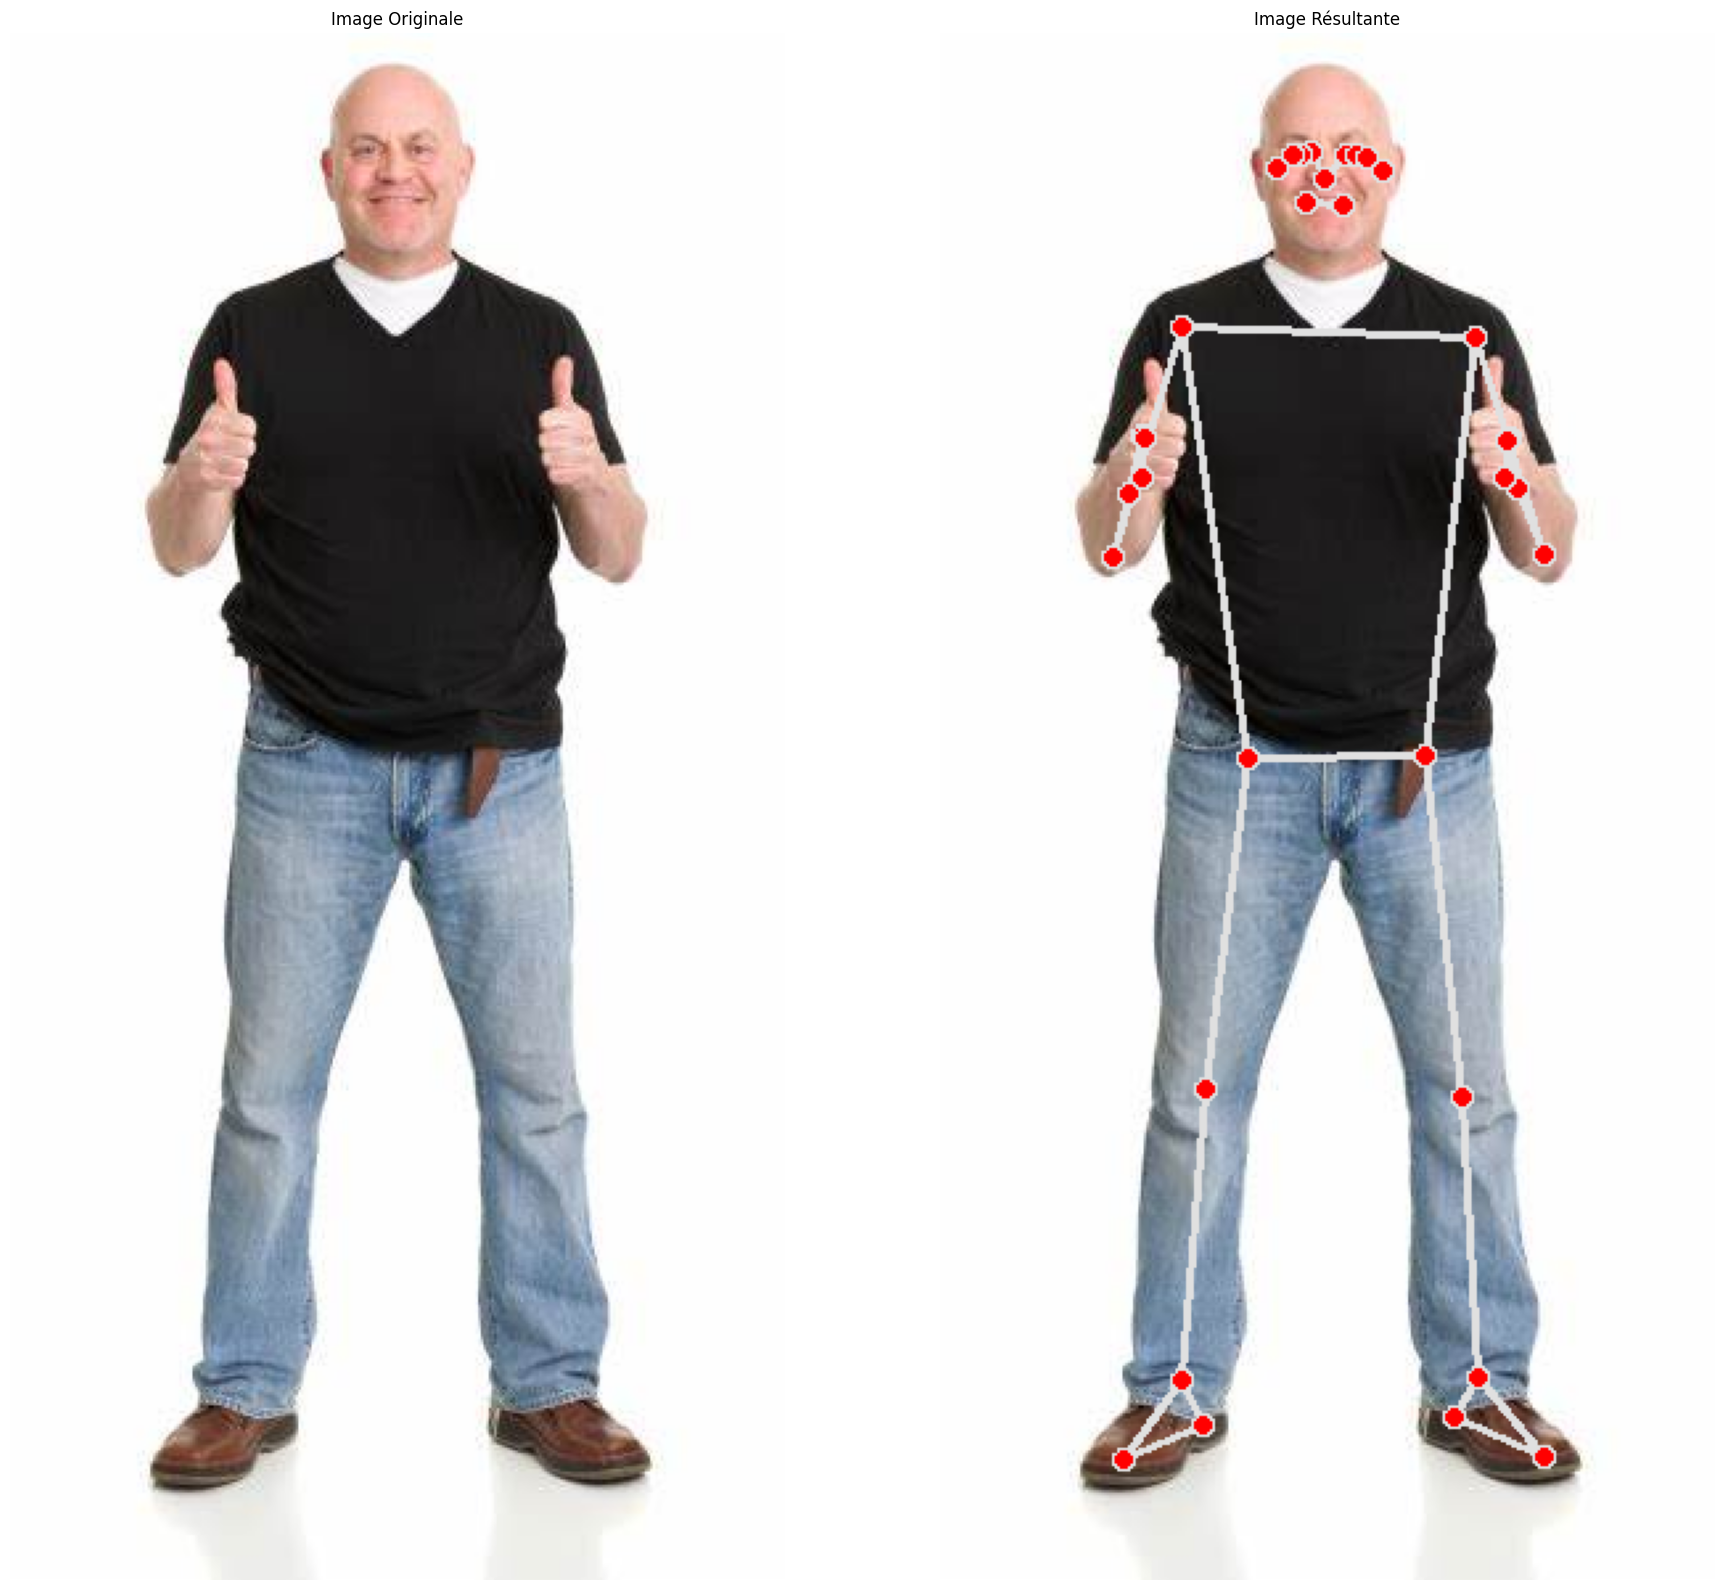

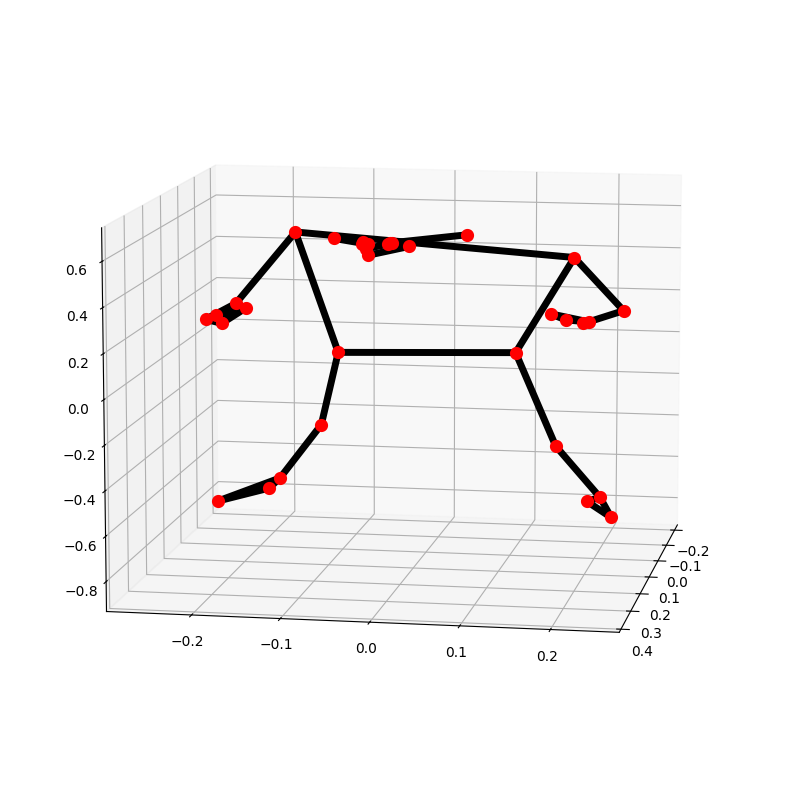

In [10]:
image = cv2.imread('media/sample.jpg')
detectPose(image, pose, display=True)

## Détection de Pose sur Vidéo Webcam en Temps Réel

Les résultats sur les images étaient plutôt bons ; maintenant, nous allons tester la fonction sur un flux webcam en temps réel et une vidéo. Selon que vous souhaitiez exécuter la détection de pose sur une vidéo stockée sur le disque ou sur le flux webcam, vous pouvez commenter ou décommenter le code d'initialisation de l'objet `VideoCapture` en conséquence.


In [9]:
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# Initialiser l'objet VideoCapture pour lire à partir de la webcam.
video = cv2.VideoCapture(0)

# Créer une fenêtre nommée pour les besoins de redimensionnement.
cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)

# Initialiser l'objet VideoCapture pour lire à partir d'une vidéo stockée sur le disque.
# video = cv2.VideoCapture('media/running.mp4')

# Définir la taille de la caméra vidéo.
video.set(3, 1280)
video.set(4, 960)

# Initialiser une variable pour stocker l'heure de la trame précédente.
time1 = 0

# Itérer jusqu'à ce que la vidéo soit accessible avec succès.
while video.isOpened():
    
    # Lire une trame.
    ok, frame = video.read()
    
    # Vérifier si la trame n'est pas lue correctement.
    if not ok:
        
        # Sortir de la boucle.
        break
    
    # Retourner la trame horizontalement pour une visualisation naturelle (vue selfie).
    frame = cv2.flip(frame, 1)
    
    # Obtenir la largeur et la hauteur de la trame.
    frame_height, frame_width, _ = frame.shape
    
    # Redimensionner la trame en conservant le rapport d'aspect.
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    
    # Effectuer la détection des repères de pose.
    frame, _ = detectPose(frame, pose_video, display=False)
    
    # Définir le temps pour cette trame au temps actuel.
    time2 = time()
    
    # Vérifier si la différence entre le temps précédent et ce temps est > 0 pour éviter la division par zéro.
    if (time2 - time1) > 0:
    
        # Calculer le nombre de trames par seconde.
        frames_per_second = 1.0 / (time2 - time1)
        
        # Écrire le nombre calculé de trames par seconde sur la trame.
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    
    # Mettre à jour le temps de la trame précédente à ce temps de trame.
    # Comme cette trame deviendra la trame précédente lors de la prochaine itération.
    time1 = time2
    
    # Afficher la trame.
    cv2.imshow('Pose Detection', frame)
    
    
    # Sortir de la boucle sur la touche 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libérer l'objet VideoCapture.
video.release()

# Fermer les fenêtres.
cv2.destroyAllWindows()
